# `photoeccentric` Tutorial

In this tutorial, I will create a simulated transit based on a Kepler planet and demonstrate how to use `photoeccentric` to recover a planet's eccentricity posterior using the photoeccentric effect [(Dawson & Johnson 2012)](https://arxiv.org/pdf/1203.5537.pdf).

The code I'm using can be viewed/downloaded here: https://github.com/ssagear/photoeccentric

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import astropy.units as u
import os
import scipy
import random

import corner

import photoeccentric as ph

%load_ext autoreload
%autoreload 2


## Defining a "test planet"


I'm going to pick a planet from our sample to test how well `photoeccentric` works. Here, I'm picking KOI 818.01 (Kepler-691 b), a super-Earth orbiting an M dwarf. It has an orbital period of about 8 days.

[KOI 818.01 Exoplanet Catalog Entry](https://exoplanets.nasa.gov/exoplanet-catalog/4987/kepler-818-b/)

In [2]:
nkoi = 818.01

I'll read in a file with the stellar information.

In [3]:
rhog = np.genfromtxt('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/HiPerGator/HPG_Replica/DR25StellarPriors/818.01/rho_star.txt')
rho_mean = np.mean(rhog)
rho_std = np.std(rhog)

stellar_params = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/HiPerGator/HPG_Replica/DR25StellarPriors/818.01/data.csv')

I'll define a KeplerStar object with `ph.KeplerStar(skoi)`, where `skoi` is the integer KOI identifier (818 for KOI 818.01).

In [4]:
SKOI = int(np.floor(float(nkoi)))
print('SKOI', SKOI)

star = ph.KeplerStar(SKOI)

# These lines are temporary. Todo: add functionality to calculate stellar mass, radii and density.
star.mstar = stellar_params[stellar_params['KOI'] == 'Mann2019_Mstar'].values[0][1]
star.rstar = stellar_params[stellar_params['KOI'] == 'Rstar'].values[0][1]
star.rho_star = rho_mean

SKOI 818


The stellar mass and radius are stored as attributes `KeplerStar.mstar, KeplerStar.rstar` respectively.

In [5]:
print('Stellar Mass (Msol): ', star.mstar)
print('Stellar Radius (Rsol): ', star.rstar)

Stellar Mass (Msol):  0.5645439787599338
Stellar Radius (Rsol):  0.5583253187213116


Now, I can define a KOI object with `ph.KOI(nkoi, SKOI, isodf)` where `nkoi` is the KOI planet identifier (818.01 in this case), `SKOI` is the integer KOI identifier as above, and `isodf` is a `pandas` dataframe constaining the consistent MESA stellar isochrones, which we created above.

The `koi` object will have all the same attributes as the `KeplerStar` object -- defining a `KeplerStar` object is not explicitly necessary.

In [6]:
isodf = 'x'
koi = ph.KOI(nkoi, SKOI)

I'm pulling the planet parameters of Kepler-691 b from the exoplanet archive using `ph.planet_params_from_archive()`. This will give me the published period, radius ratio, inclination, and more parameters for this planet.

I can use `koi.get_KIC` to get the Kepler Input Catalog number for the KOI.

And I can use the `koi.download_planet_params()` function to download planet properties from the Exoplanet Archive. The properties will become attributes of the `koi` object.

In [7]:
koi.download_planet_params()

print('Period (days): ', koi.period)
print('Rp/Rs: ', koi.rprs)
print('a/Rs: ', koi.a_rs)
print('b: ', koi.b)

Period (days):  8.11437482
Rp/Rs:  0.037204
a/Rs:  23.58
b:  0.573


In [41]:
koi.download_lightcurves()
koi.get_stitched_lcs()

COMPLETE:  mastDownload.tar.gz


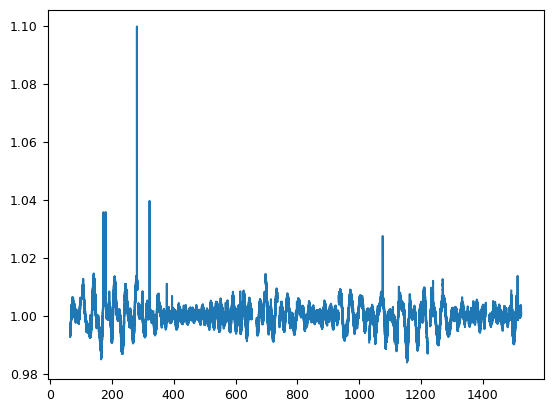

In [43]:
plt.plot(koi.time, koi.flux)

## Creating a fake light curve based on a real planet

I'm calculating a/Rs using `ph.calc_a()`, instead of using the a/Rs constraint from the Exoplanet Archive. The reason is because a/Rs must be consistent with the density calculated above from spectroscopy/Gaia for the photoeccentric effect to work correctly, and the published a/Rs is often inconsistent. a/Rs depends on the orbital period, Mstar, and Rstar.


Let's force the inclination to be 90 degrees for this example.

In [89]:
# These lines are temporary. Todo: have KOI object inherit stellar params
koi.mstar = stellar_params[stellar_params['KOI'] == 'Mann2019_Mstar'].values[0][1]
koi.rstar = stellar_params[stellar_params['KOI'] == 'Rstar'].values[0][1]
koi.rho_star = rho_mean
koi.rho_star_err = rho_std

koi.calc_a(koi.mstar, koi.rstar)

print('Stellar mass (Msun): ', koi.mstar, 'Stellar radius (Rsun): ', koi.rstar)
print('Period (Days): ', koi.period, 'Rp/Rs: ', koi.rprs)
print('a/Rs: ', koi.a_rs)

koi.i = 90.
print('i (deg): ', koi.i)

Stellar mass (Msun):  0.5645439787599338 Stellar radius (Rsun):  0.5583253187213116
Period (Days):  8.11437482 Rp/Rs:  0.037204
a/Rs:  25.131996651339033
i (deg):  90.0


Now, I'll create a fake transit using `batman`.
I'm creating a model with the period, Rp/Rs, a/Rs, and inclination specified by the Kepler catalog entry and the density constraints.

I'll create the transit model with an $e$ and $w$ of my choice. This will allow me to test whether `photoeccentric` accurately recovers the $(e,w)$ combination I have input. I'll start with $e = 0.0$ and $w = 90.0$ degrees.

## Test Case 1: $e = 0.0$, $\omega = 90.0$

I
define a cadence length (~30  minutes, in days) that matches the Kepler long-cadence integration time, so I can create a fake light curve that integrates over the same time as real Kepler light curves.

I want to replicate the real Kepler light curve as closely as possible. So I am taking these parameters fromm the light curves

In [90]:
# Define the working directory
direct = 'tutorial01_Test/' + str(nkoi) + '/e_0.0_w_90.0/'
if not os.path.exists(direct):
    os.makedirs(direct)

First, reading in the light curves that I have saved for this planet.

In [11]:
KICs = np.sort(np.unique(np.array(DR25['KIC'])))
KOIs = np.sort(np.unique(np.array(DR25['KOI'])))

# Remove the get_lc_files function. Auto download from MAST, or have the user specify a path.
files = ph.get_lc_files(koi.KIC, KICs, lcpath)

In [12]:
# Stitching the light curves together, preserving the time stamps
koi.get_stitched_lcs(files)

# Getting the midpoint times
koi.get_midpoints()

In [13]:
starttime = koi.time[0]
endtime = koi.time[-1]

In [14]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(starttime, endtime, cadence)

In [15]:
# Define e and w, calculate flux from transit model
e = 0.0
w = 90.0
import batman 

params = batman.TransitParams()       #object to store transit parameters
params.t0 = koi.epoch                 #time of inferior conjunction
params.per = koi.period               #orbital period
params.rp = koi.rprs                  #planet radius (in units of stellar radii)
params.a = koi.a_rs                   #semi-major axis (in units of stellar radii)
params.inc = koi.i                    #orbital inclination (in degrees)
params.ecc = e                        #eccentricity
params.w = w                          #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = time
m = batman.TransitModel(params, t, supersample_factor = 29, exp_time = 0.0201389)

In [16]:
flux = m.light_curve(params)

Text(0.5, 1.0, 'Transit LC Model')

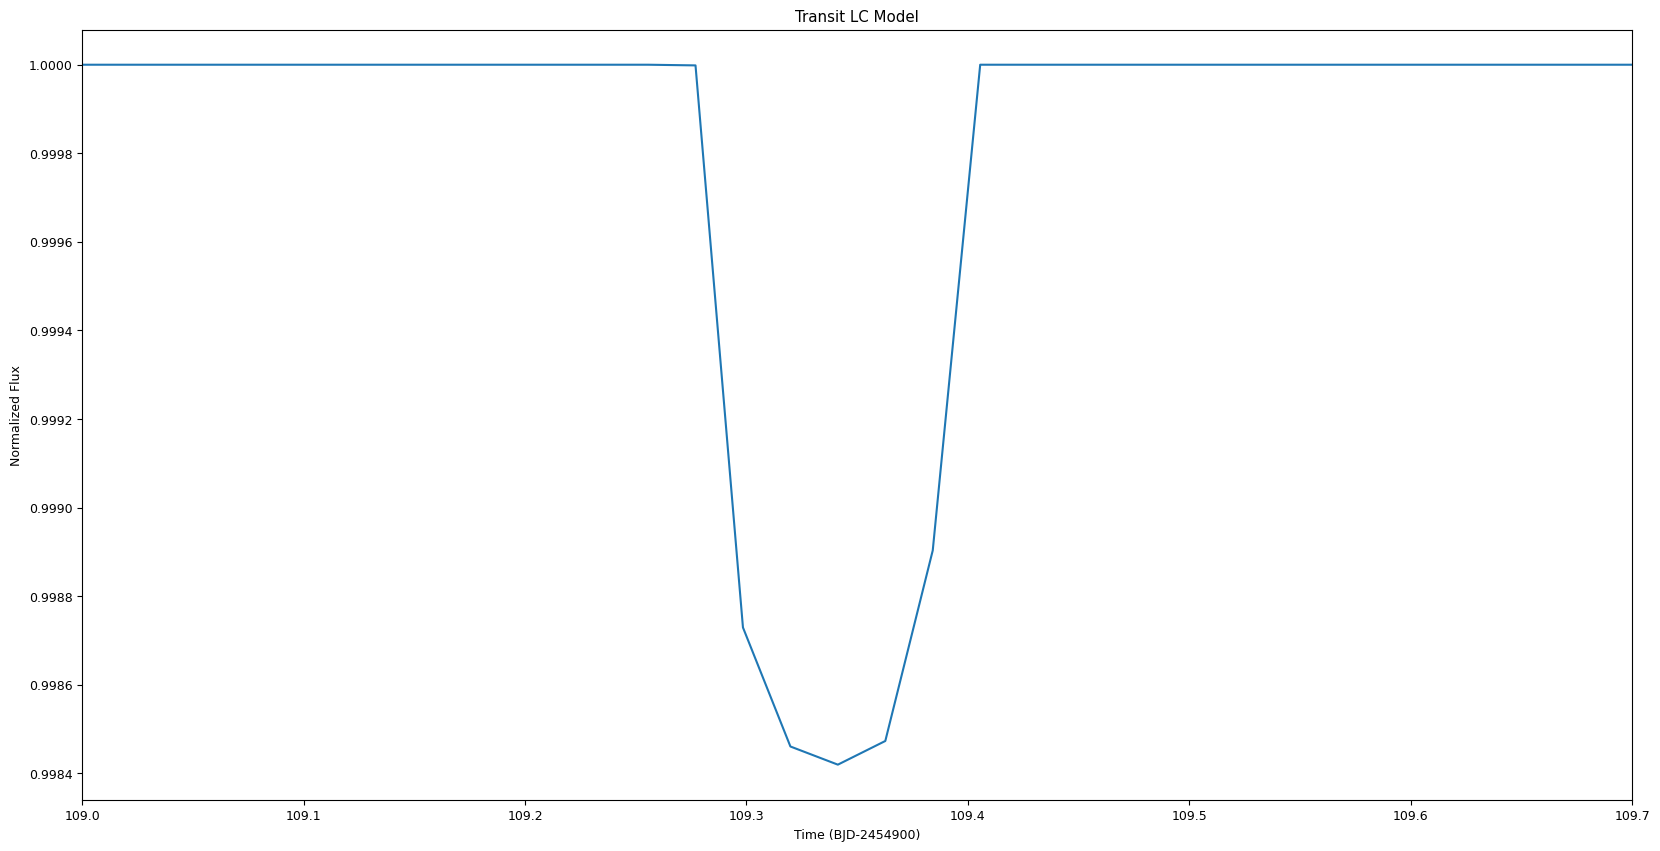

In [17]:
time = time
flux = flux

plt.plot(time, flux)
plt.xlim(109,109.7)
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Normalized Flux')
plt.title('Transit LC Model')

To create a light curve with a target signal to noise ratio, we need the transit duration, number of transits, and the number of points in each transit, and the transit depth.

In [18]:
tduration = koi.dur/24.0

N = round(ph.get_N_intransit(tduration, cadence))
ntransits = len(koi.midpoints)
depth = koi.rprs**2

The magnitude of each individual error bar:

In [19]:
errbar = ph.get_sigma_individual(60, N, ntransits, depth)

Adding gaussian noise to produce a light curve with the target SNR:

(NB: the noise is gaussian and uncorrelated, unlike the noise in real Kepler light curves)

In [20]:
noise = np.random.normal(0,errbar,len(time))
nflux = flux+noise

flux_err = np.array([errbar]*len(nflux))

Text(0.5, 1.0, 'Transit LC Model with Noise')

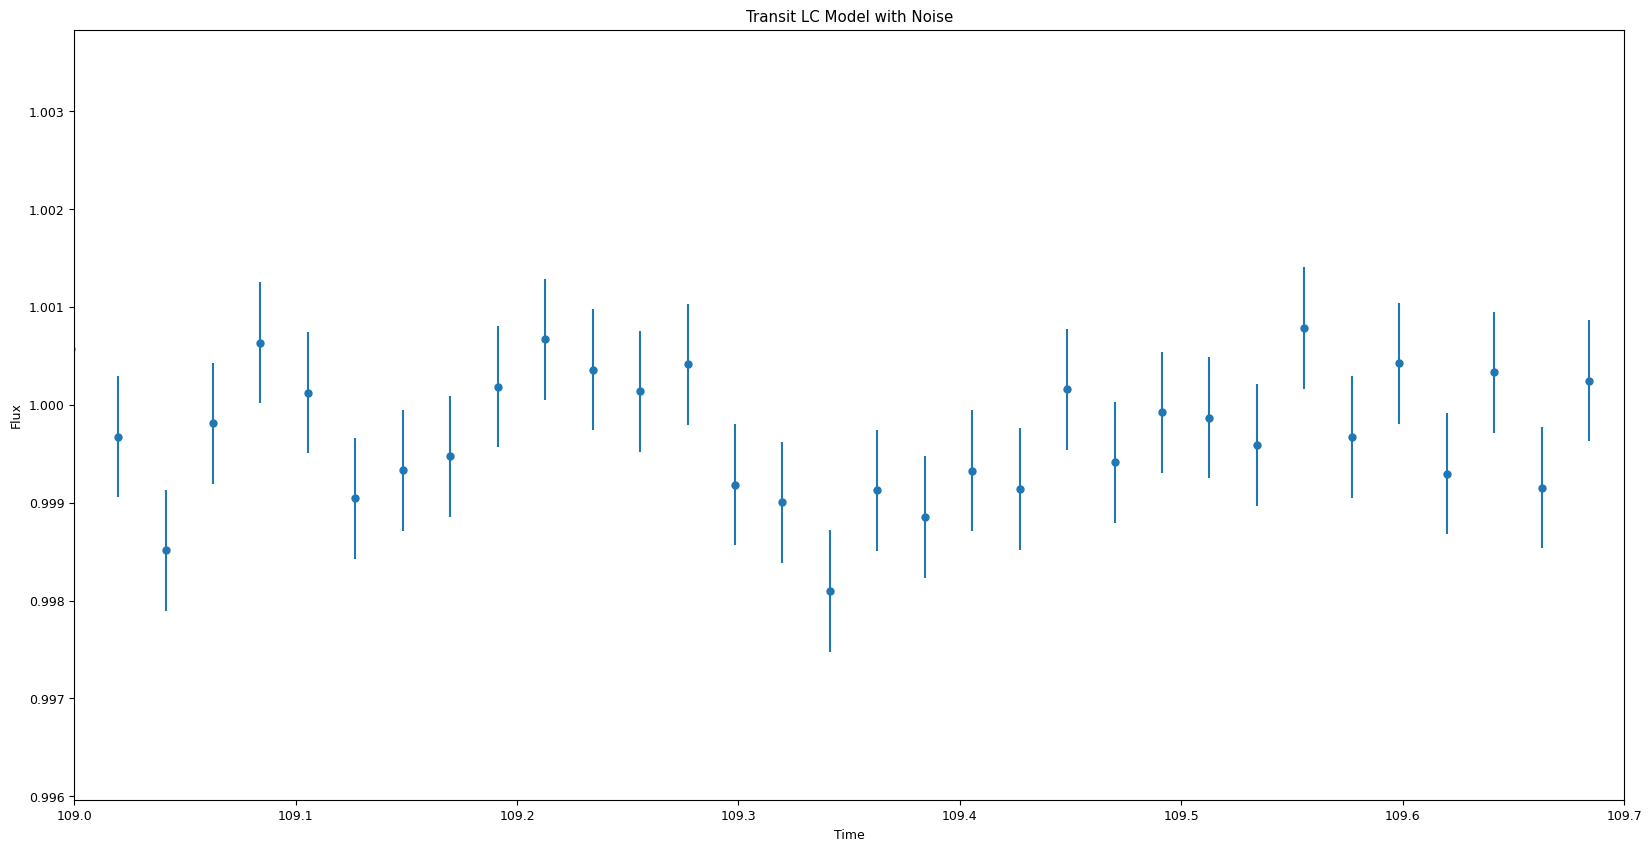

In [21]:
plt.errorbar(time, nflux, yerr=flux_err, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(109,109.7)
plt.title('Transit LC Model with Noise')

### Getting the stellar density prior

In [33]:
koi.rho_star = ph.get_rho_prior(koi.period, koi.rprs, koi.a_rs, koi.i, e, w)
koi.rho_star_err = 1

In [35]:
koi.rho_star

3.2338290600579285

### Fitting the transit


`photoeccentric` includes functionality to fit using `exoplanet`.

First, I'll fit the transit shape with `exoplanet`. $P$, $t0$, $Rp/Rs$, $rho_star$, $b$, $sesinw$ and $secosw$ are allowed to vary as free parameters. 

In [36]:
koi.time = time
koi.flux = nflux
koi.flux_err = flux_err

Let's just do the first 7 transits.

In [37]:
koi.midpoints = koi.midpoints[0:7]

In [38]:
koi.remove_oot_data(7, 6)

100%|██████████| 7/7 [00:00<00:00, 1659.89it/s]


Text(0.5, 1.0, 'Transit LC Model with Noise')

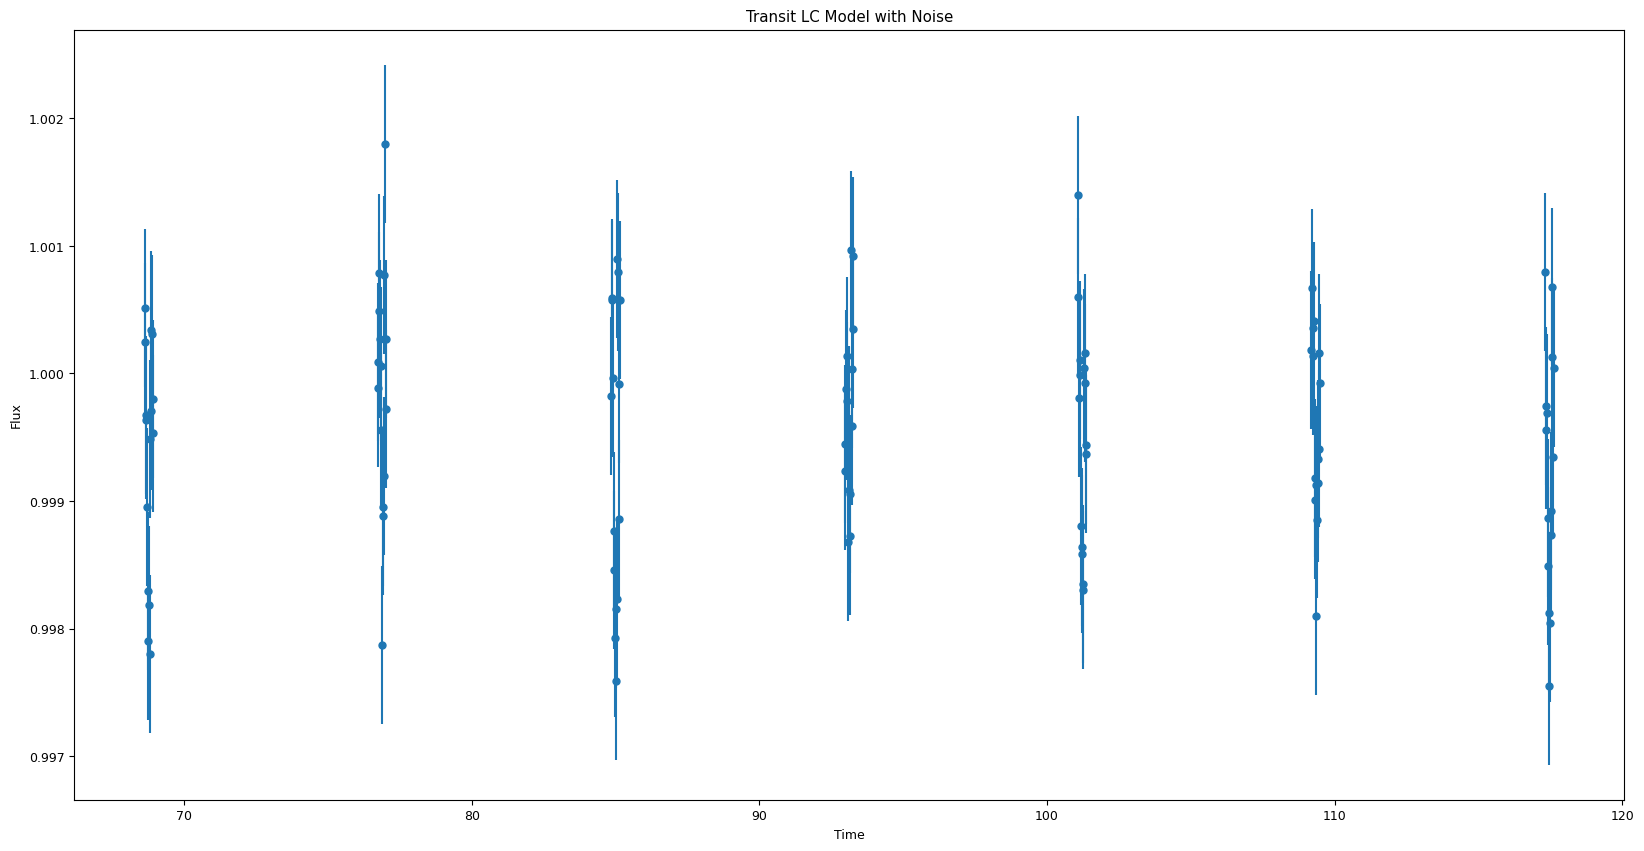

In [39]:
plt.errorbar(koi.time_intransit, koi.flux_intransit, yerr=koi.fluxerr_intransit, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Transit LC Model with Noise')

In [40]:
nsupersample=29
exptimesupersample=0.0201389

In [41]:
koi.period

8.11437482

In [45]:
trace = koi.do_tfit_exoplanet(direct, oversample=nsupersample, exptime=exptimesupersample)

Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [ecs, ror, rho_star, q2, q1, b, t0, period]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 819 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8408639565053505, but should be close to 0.9. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9637093687962793, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


In [48]:
import arviz as az

az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
q1,0.42400,0.12500,0.23600,0.67200,0.01200,0.00800,117.00000,131.00000,1.00000
q2,0.29500,0.00600,0.28400,0.30500,0.00000,0.00000,310.00000,115.00000,1.03000
rho_star,4.06600,1.25500,1.93000,6.25000,0.22000,0.15700,29.00000,12.00000,1.09000
period,8.11400,0.00000,8.11400,8.11400,0.00000,0.00000,251.00000,187.00000,1.00000
t0,109.34100,0.00100,109.34000,109.34300,0.00000,0.00000,202.00000,155.00000,1.01000
b,-0.06800,0.34700,-0.58500,0.45700,0.11100,0.08100,18.00000,58.00000,1.11000
ror,0.03700,0.00100,0.03600,0.03800,0.00000,0.00000,35.00000,130.00000,1.04000
r_pl,0.02100,0.00000,0.02000,0.02100,0.00000,0.00000,35.00000,130.00000,1.04000
"ecs[0, 0]",0.16300,0.38600,-0.55500,0.69400,0.06200,0.05600,32.00000,61.00000,1.05000
"ecs[1, 0]",-0.14200,0.20500,-0.48700,0.25100,0.04600,0.03300,23.00000,31.00000,1.07000



Below, I plot the transit fit corner plot.

Because I input $e = 0.0$, the transit fitter should return close to the same parameters I input (because the transit fitter always requires $e = 0.0$).

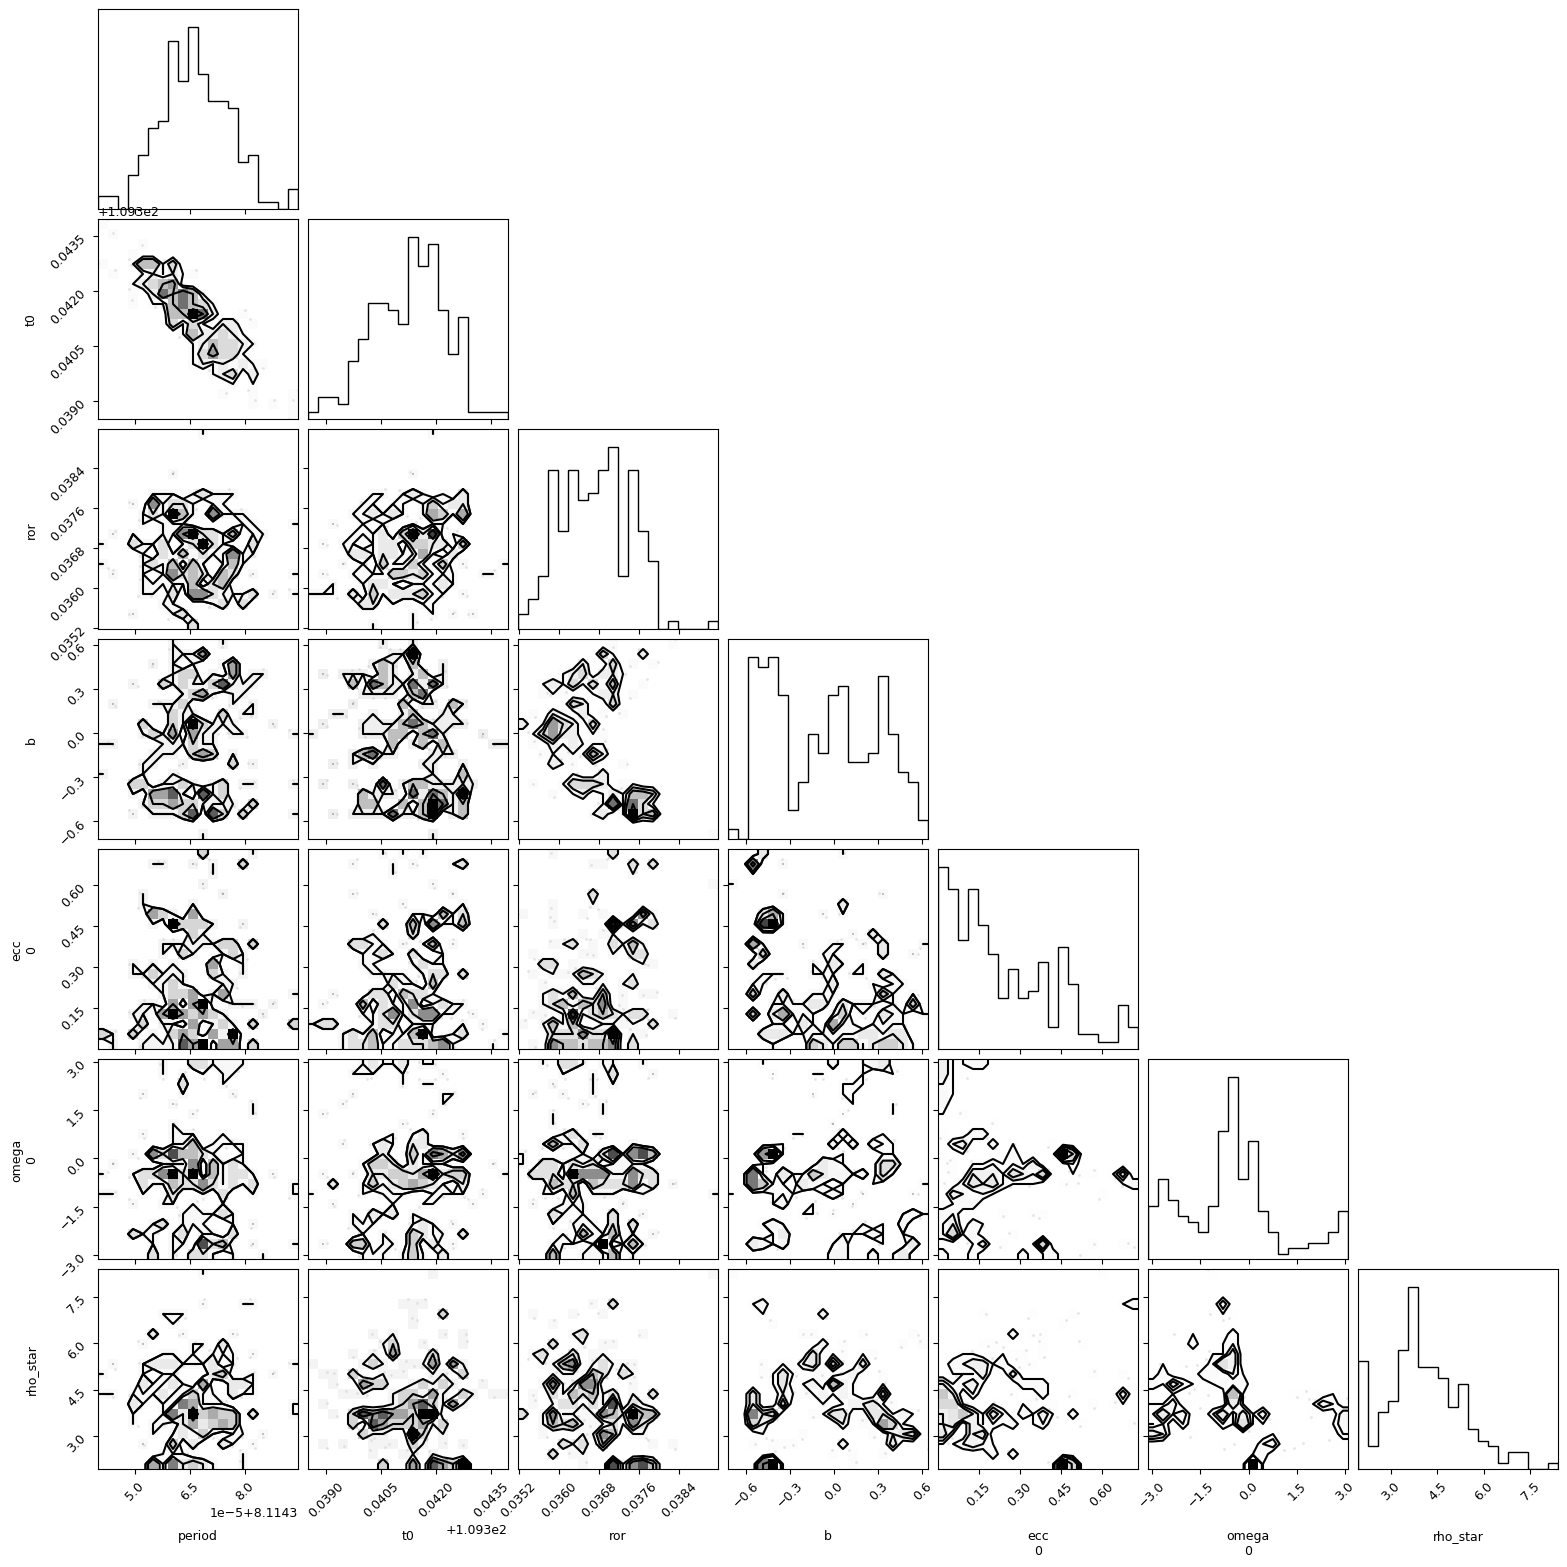

In [55]:
_ = corner.corner(trace, var_names=['period', 't0', 'ror', 'b', 'ecc', 'omega', 'rho_star'])

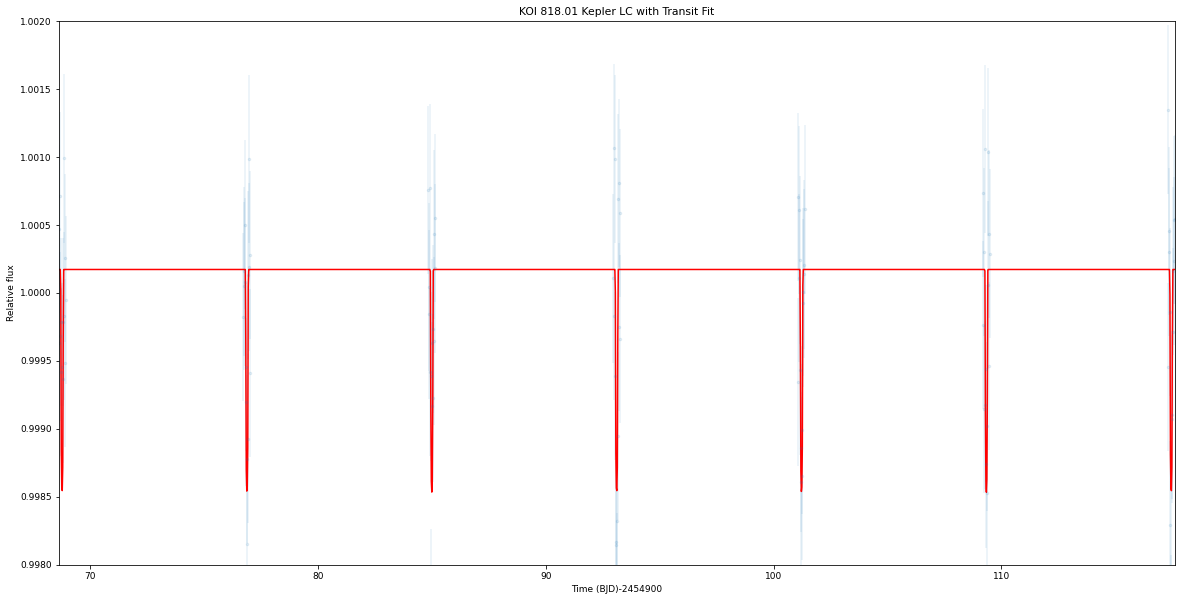

In [54]:
samples = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p = np.median(samples["period"])
t0 = np.median(samples["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned")

# Plot the folded model
pred = np.percentile(samples["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc, pred[1], color="C1", label="model")
art = plt.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(samples["period"].values), np.std(samples["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
_ = plt.xlim(-0.15, 0.15)

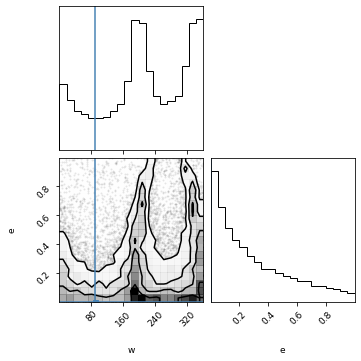

In [63]:
labels = ["w", "e"]

fig = corner.corner(ewdres.samples, labels=labels, title_kwargs={"fontsize": 12}, truths=[w, e], plot_contours=True)

And here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 1$. The $e$ distribution peaks at 0!

## Test Case 2: $e = 0.3$, $\omega = 90.0$

Now let's repeat this example with an eccentricity of 0.3 at periapse.

In [64]:
# Define the working directory
direct = 'tutorial01/' + str(nkoi) + '/e_0.3_w_90.0/'

In [65]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(starttime, endtime, cadence)

In [66]:
# Define e and w, calculate flux from transit model
e = 0.3
w = 90.0

params = batman.TransitParams()       #object to store transit parameters
params.t0 = koi.epoch                 #time of inferior conjunction
params.per = koi.period               #orbital period
params.rp = koi.rprs                  #planet radius (in units of stellar radii)
params.a = koi.a_rs                   #semi-major axis (in units of stellar radii)
params.inc = koi.i                    #orbital inclination (in degrees)
params.ecc = e                        #eccentricity
params.w = w                          #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = time
m = batman.TransitModel(params, t, supersample_factor = 29, exp_time = 0.0201389)

In [67]:
flux = m.light_curve(params)

Text(0.5, 1.0, 'Transit LC Model')

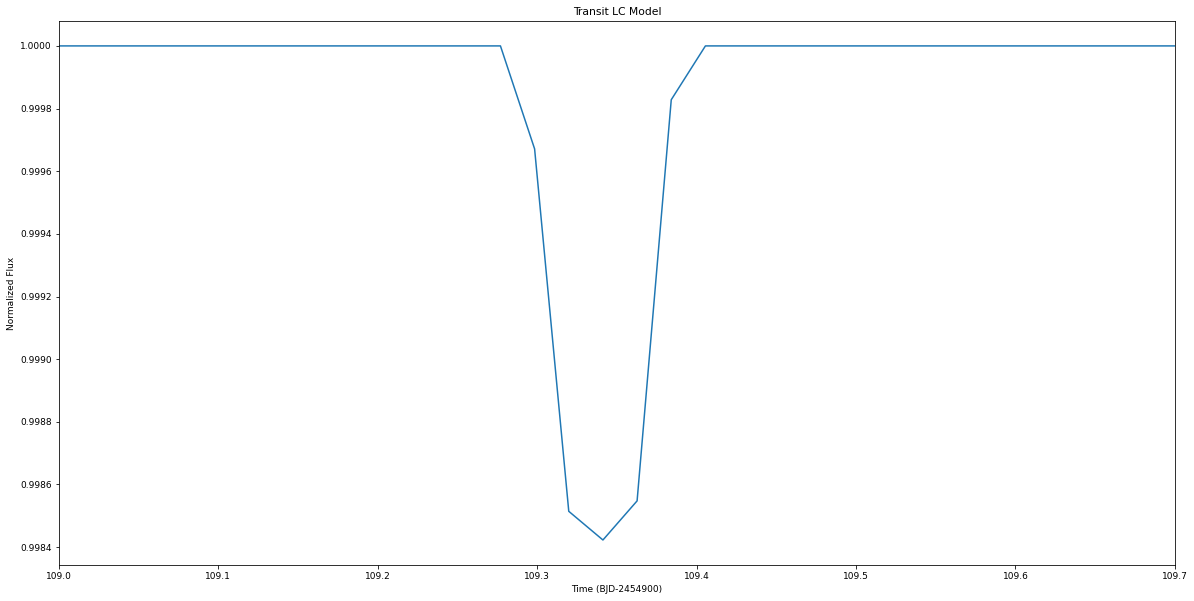

In [68]:
time = time
flux = flux

plt.plot(time-2454900, flux)
plt.xlim(109,109.7)
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Normalized Flux')
plt.title('Transit LC Model')

To create a light curve with a target signal to noise ratio, we need the transit duration, number of transits, and the number of points in each transit, and the transit depth.

In [69]:
tduration = koi.dur/24.0

N = round(ph.get_N_intransit(tduration, cadence))
ntransits = len(koi.midpoints)
depth = koi.rprs**2

The magnitude of each individual error bar:

In [70]:
errbar = ph.get_sigma_individual(60, N, ntransits, depth)

Adding gaussian noise to produce a light curve with the target SNR:

In [71]:
noise = np.random.normal(0,errbar,len(time))
nflux = flux+noise

flux_err = np.array([errbar]*len(nflux))

Text(0.5, 1.0, 'Transit LC Model with Noise')

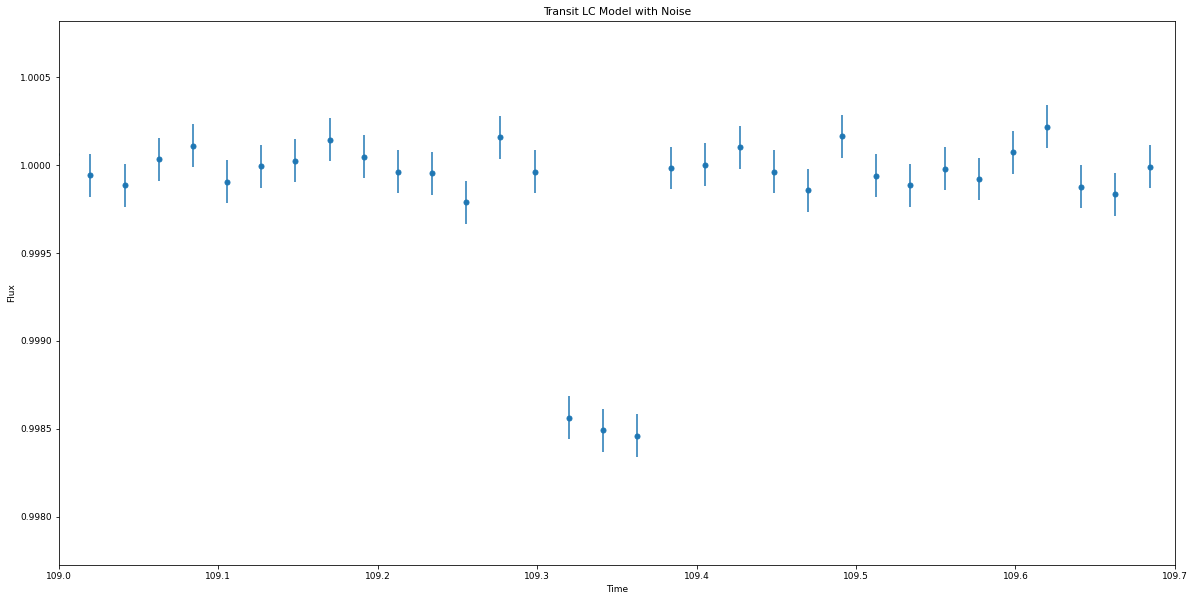

In [72]:
plt.errorbar(time-2454900, nflux, yerr=flux_err, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(109,109.7)
plt.title('Transit LC Model with Noise')

### Fitting the transit


`photoeccentric` includes functionality to fit using `juliet` with `multinest`.

First, I'll fit the transit shape with `juliet`. $Rp/Rs$, $a/Rs$, $i$, and $w$ are allowed to vary as free parameters. 

The transit fitter, `ph.planetlc_fitter`, fixes $e = 0.0$, even if the input eccentricity is not zero! This means that if e is not 0, the transit fitter will fit the "wrong" values for $a/Rs$ and $i$ -- but they will be wrong in such a way that reveals the eccentricity of the orbit. More on that in the next section.

I enter an initial guess based on what I estimate the fit parameters will be. For this one, I'll enter values close to the Kepler archive parameters.

In [73]:
koi.time = time
koi.flux = nflux
koi.flux_err = flux_err

Let's just do the first 7 transits.

In [74]:
koi.midpoints = koi.midpoints[0:7]

In [75]:
koi.remove_oot_data(7, 6)

Text(0.5, 1.0, 'Transit LC Model with Noise')

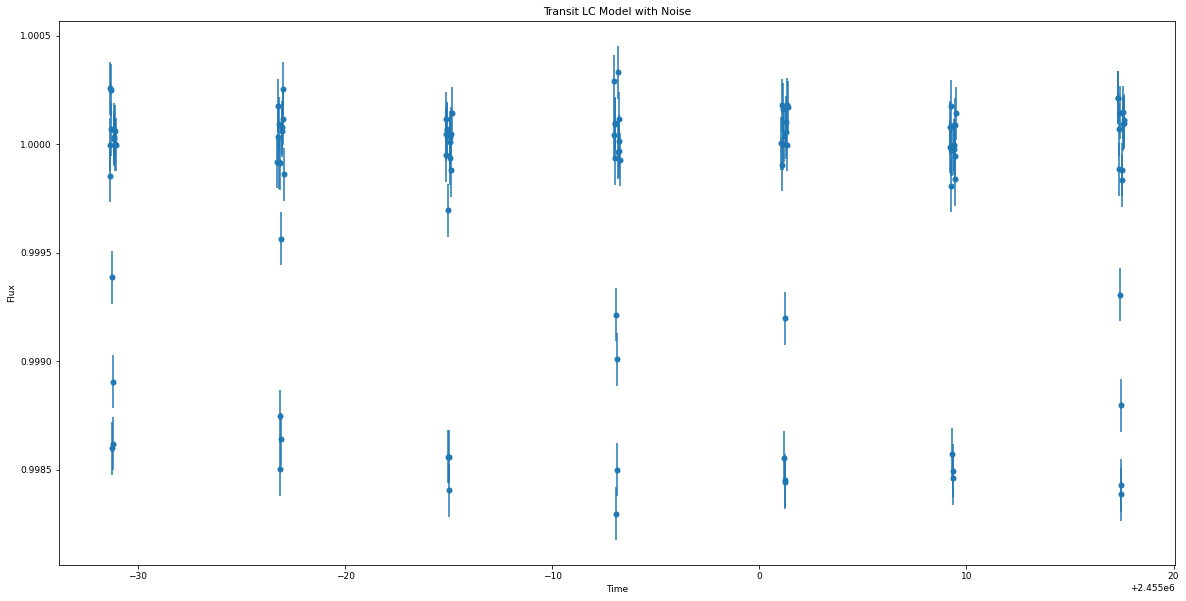

In [76]:
plt.errorbar(koi.time_intransit, koi.flux_intransit, yerr=koi.fluxerr_intransit, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Transit LC Model with Noise')

In [77]:
nlive=1000
nsupersample=29
exptimesupersample=0.0201389

In [78]:
dataset, results = koi.do_tfit_juliet(direct, nsupersample=nsupersample, exptimesupersample=exptimesupersample, nlive=nlive)

  analysing data from tutorial01/818.01/e_0.3_w_90.0/jomnest_.txt


In [79]:
res = pd.read_table(direct + 'posteriors.dat')

In [80]:
# Print transit fit results from Juliet
res

,# Parameter Name,,Median,.1,Upper 68 CI,.2,Lower 68 CI
0,P_p1,,8.11447,,0.00020,,0.00020
1,t0_p1,,2455009.34045,,0.00050,,0.00053
2,p_p1,,0.03779,,0.00074,,0.00081
3,b_p1,,0.25005,,0.20836,,0.16863
4,q1_KEPLER,,0.24137,,0.33555,,0.16504
5,q2_KEPLER,,0.20592,,0.33467,,0.14925
6,a_p1,,34.01496,,1.53172,,2.81683
7,mflux_KEPLER,,-0.00005,,0.00001,,0.00001
8,sigma_w_KEPLER,,1.76799,,10.52057,,1.49476


In [81]:
# Save fit planet parameters to variables for convenience
per_f = res.iloc[0][2]
t0_f = res.iloc[1][2]
rprs_f = res.iloc[2][2]
b_f = res.iloc[3][2]
a_f = res.iloc[6][2]

i_f = np.arccos(b_f*(1./a_f))*(180./np.pi)


Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

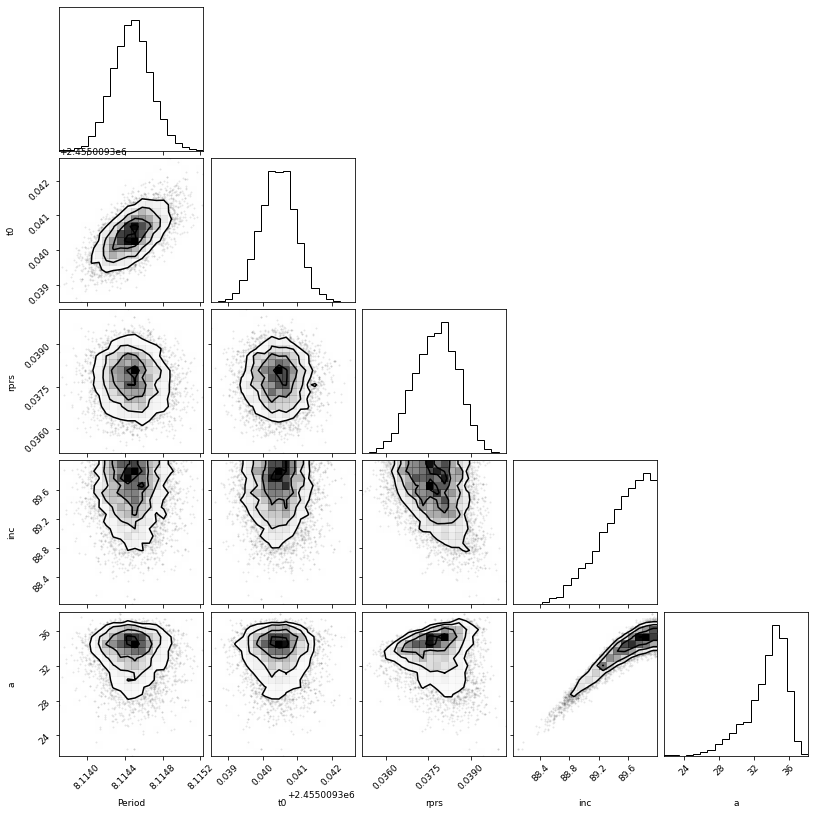

In [82]:
# Plot the transit fit corner plot
p = results.posteriors['posterior_samples']['P_p1']
t0 = results.posteriors['posterior_samples']['t0_p1']
rprs = results.posteriors['posterior_samples']['p_p1']
b = results.posteriors['posterior_samples']['b_p1']
a = results.posteriors['posterior_samples']['a_p1']
inc = np.arccos(b*(1./a))*(180./np.pi)

params = ['Period', 't0', 'rprs', 'inc', 'a']

fs = np.vstack((p, t0, rprs, inc, a))
fs = fs.T

figure = corner.corner(fs, labels=params)

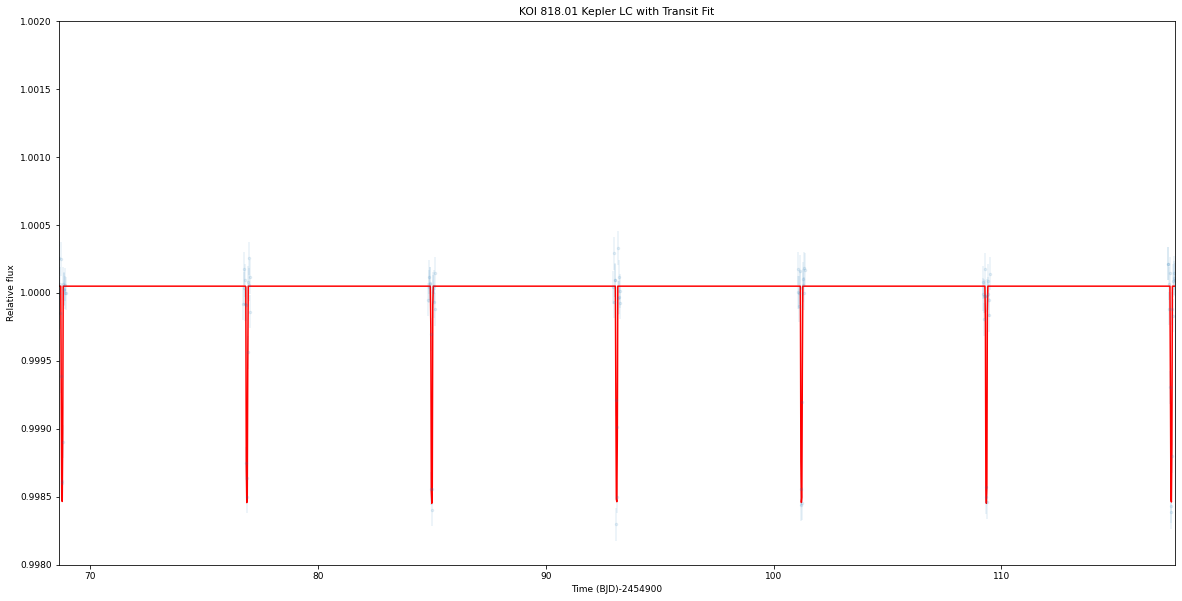

In [83]:
# Plot the data:
plt.errorbar(dataset.times_lc['KEPLER']-2454900, dataset.data_lc['KEPLER'], \
             yerr = dataset.errors_lc['KEPLER'], fmt = '.', alpha = 0.1)

# Plot the model:
plt.plot(dataset.times_lc['KEPLER']-2454900, results.lc.evaluate('KEPLER'), c='r')

# Plot portion of the lightcurve, axes, etc.:
plt.xlabel('Time (BJD)-2454900')
plt.xlim(np.min(dataset.times_lc['KEPLER'])-2454900, np.max(dataset.times_lc['KEPLER'])-2454900)
plt.ylim(0.998, 1.002)
plt.ylabel('Relative flux')
plt.title('KOI 818.01 Kepler LC with Transit Fit')
plt.show()

### Determining T14 and T23

In [84]:
koi.calc_durations()

In [85]:
print('Total Transit Duration: ', np.mean(koi.T14_dist), '-/+', koi.T14_errs, 'hours')
print('Full Transit Duration: ', np.mean(koi.T23_dist), '-/+', koi.T23_errs, 'hours')

Total Transit Duration:  0.07624977166072124 -/+ (0.001938522023045397, 0.0022380238235224087) hours
Full Transit Duration:  0.0700019311019035 -/+ (0.0018442657065528278, 0.00209380377961145) hours


### Get $g$

Print $g$ and $\sigma_{g}$:

In [86]:
koi.get_gs()

In [87]:
g_mean = koi.g_mean
g_sigma = koi.g_sigma

In [88]:
g_mean

1.3096409093931336

In [89]:
g_sigma

0.09639732695175818

The mean of $g$ is about 1.3, which means that $\rho_{circ}$ agrees with $\rho_{star}$ and the eccentricity of this transit must be non-zero. We can take $g$ and $\sigma_{g}$ and use nested sampling (`dynesty`) to determine the surface of most likely $(e,w)$.

`photoeccentric` has the probability function for $(e,w)$ from $g$ built in to `ph.log_probability()`.

In [90]:
koi.do_eccfit(direct)

18966it [01:42, 184.48it/s, batch: 13 | bound: 0 | nc: 1 | ncall: 167069 | eff(%): 11.352 | loglstar:   -inf <  2.339 <  2.218 | logz:  0.239 +/-  0.065 | stop:  0.978]          


In [91]:
with open(direct + '/kepewdres.pickle', 'rb') as f:
    ewdres = pickle.load(f)

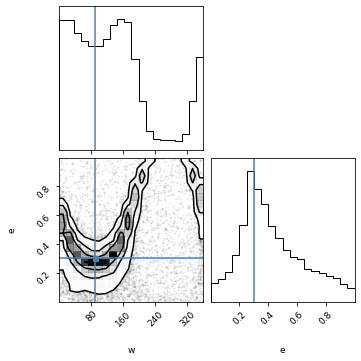

In [92]:
labels = ["w", "e"]

fig = corner.corner(ewdres.samples, labels=labels, title_kwargs={"fontsize": 12}, truths=[w, e], plot_contours=True)

And here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 1.3$. The $e$ distribution peaks at $e = 0.3$!

## Test Case 3: $e = 0.3$, $\omega = 270.0$

Now let's repeat this example with an eccentricity of 0.3 at apoapse.

In [93]:
# Define the working directory
direct = 'tutorial01/' + str(nkoi) + '/e_0.3_w_270.0/'

In [94]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(starttime, endtime, cadence)

In [95]:
# Define e and w, calculate flux from transit model
e = 0.3
w = 270.0

params = batman.TransitParams()       #object to store transit parameters
params.t0 = koi.epoch                        #time of inferior conjunction
params.per = koi.period                       #orbital period
params.rp = koi.rprs                       #planet radius (in units of stellar radii)
params.a = koi.a_rs                        #semi-major axis (in units of stellar radii)
params.inc = koi.i                      #orbital inclination (in degrees)
params.ecc = e                       #eccentricity
params.w = w                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = time
m = batman.TransitModel(params, t, supersample_factor = 29, exp_time = 0.0201389)

In [96]:
flux = m.light_curve(params)

Text(0.5, 1.0, 'Transit LC Model')

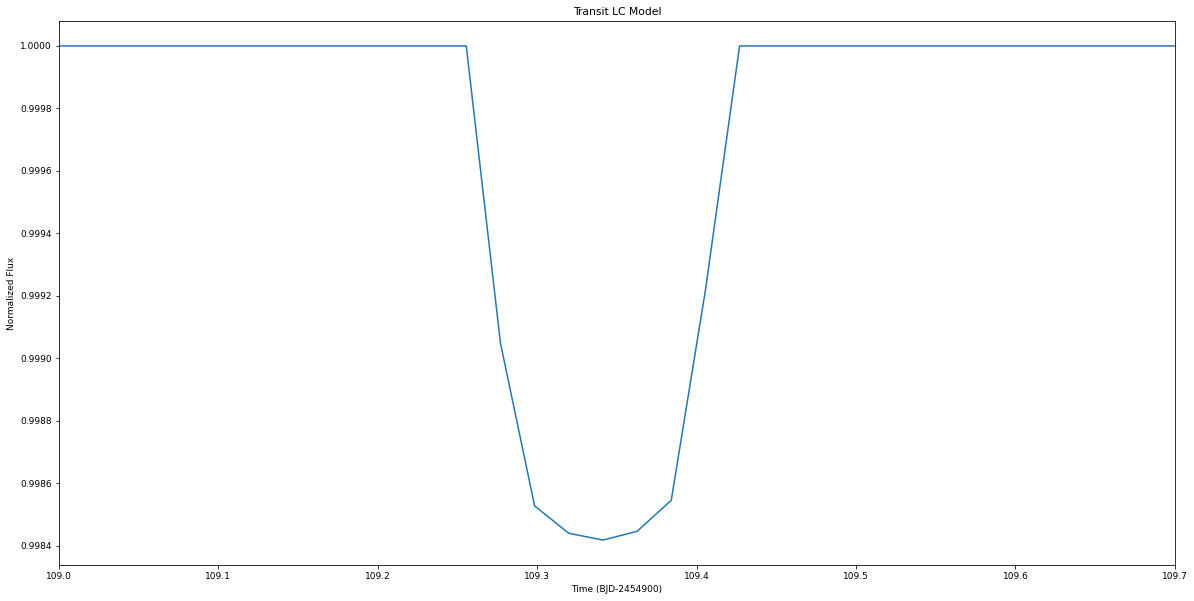

In [97]:
time = time
flux = flux

plt.plot(time-2454900, flux)
plt.xlim(109,109.7)
plt.xlabel('Time (BJD-2454900)')
plt.ylabel('Normalized Flux')
plt.title('Transit LC Model')

To create a light curve with a target signal to noise ratio, we need the transit duration, number of transits, and the number of points in each transit, and the transit depth.

In [98]:
tduration = koi.dur/24.0

N = round(ph.get_N_intransit(tduration, cadence))
ntransits = len(koi.midpoints)
depth = koi.rprs**2

The magnitude of each individual error bar:

In [99]:
errbar = ph.get_sigma_individual(60, N, ntransits, depth)

Adding gaussian noise to produce a light curve with the target SNR:

In [100]:
noise = np.random.normal(0,errbar,len(time))
nflux = flux+noise

flux_err = np.array([errbar]*len(nflux))

Text(0.5, 1.0, 'Transit LC Model with Noise')

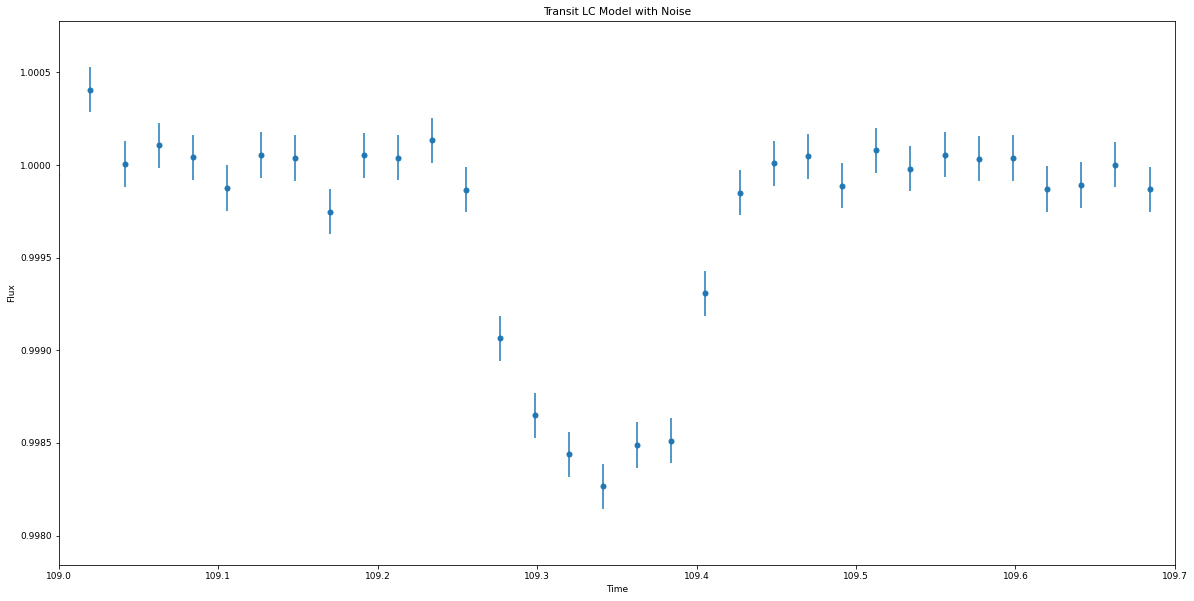

In [101]:
plt.errorbar(time-2454900, nflux, yerr=flux_err, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(109,109.7)
plt.title('Transit LC Model with Noise')

### Fitting the transit

In [102]:
koi.time = time
koi.flux = nflux
koi.flux_err = flux_err

Let's just do the first 7 transits.

In [103]:
koi.midpoints = koi.midpoints[0:7]

In [104]:
koi.remove_oot_data(7, 6)

Text(0.5, 1.0, 'Transit LC Model with Noise')

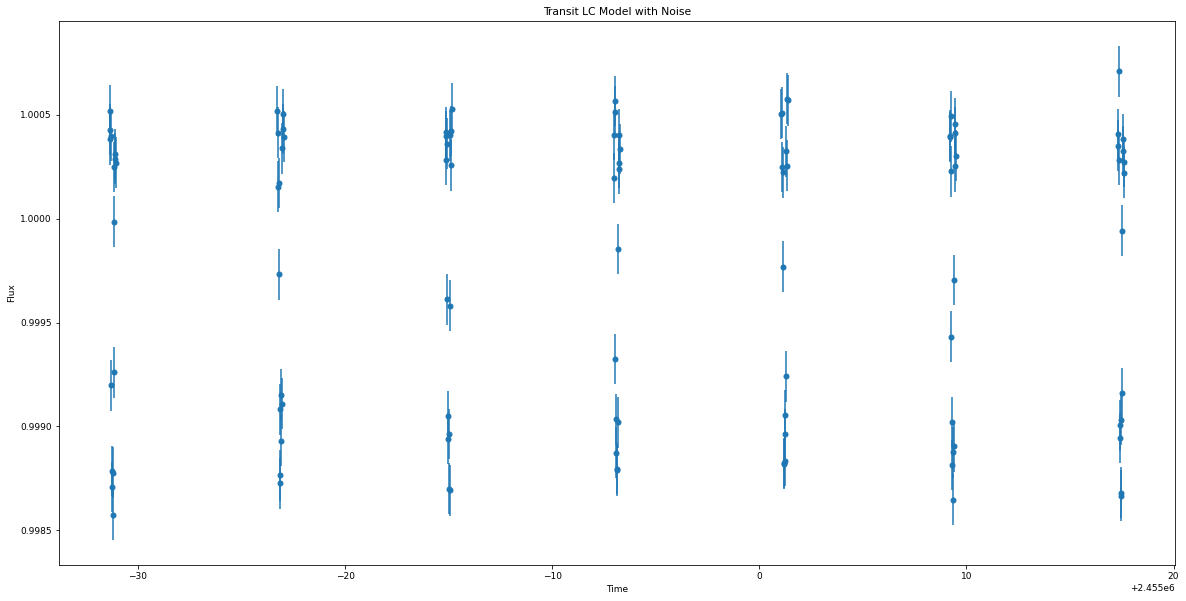

In [105]:
plt.errorbar(koi.time_intransit, koi.flux_intransit, yerr=koi.fluxerr_intransit, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Transit LC Model with Noise')

In [106]:
nlive=1000
nsupersample=29
exptimesupersample=0.0201389

In [107]:
dataset, results = koi.do_tfit_juliet(direct, nsupersample=nsupersample, exptimesupersample=exptimesupersample, nlive=nlive)

  analysing data from tutorial01/818.01/e_0.3_w_270.0/jomnest_.txt


In [108]:
res = pd.read_table(direct + 'posteriors.dat')

In [109]:
# Print transit fit results from Juliet
res

,# Parameter Name,,Median,.1,Upper 68 CI,.2,Lower 68 CI
0,P_p1,,8.11407,,0.00024,,0.00023
1,t0_p1,,2455009.34021,,0.00057,,0.00057
2,p_p1,,0.03688,,0.00069,,0.00065
3,b_p1,,0.36570,,0.17872,,0.22039
4,q1_KEPLER,,0.35974,,0.26895,,0.17441
5,q2_KEPLER,,0.29702,,0.31601,,0.18794
6,a_p1,,17.29780,,1.10237,,1.78141
7,mflux_KEPLER,,-0.00037,,0.00002,,0.00002
8,sigma_w_KEPLER,,3.34227,,24.49567,,3.00753


In [110]:
# Save fit planet parameters to variables for convenience
per_f = res.iloc[0][2]
t0_f = res.iloc[1][2]
rprs_f = res.iloc[2][2]
b_f = res.iloc[3][2]
a_f = res.iloc[6][2]

i_f = np.arccos(b_f*(1./a_f))*(180./np.pi)


Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

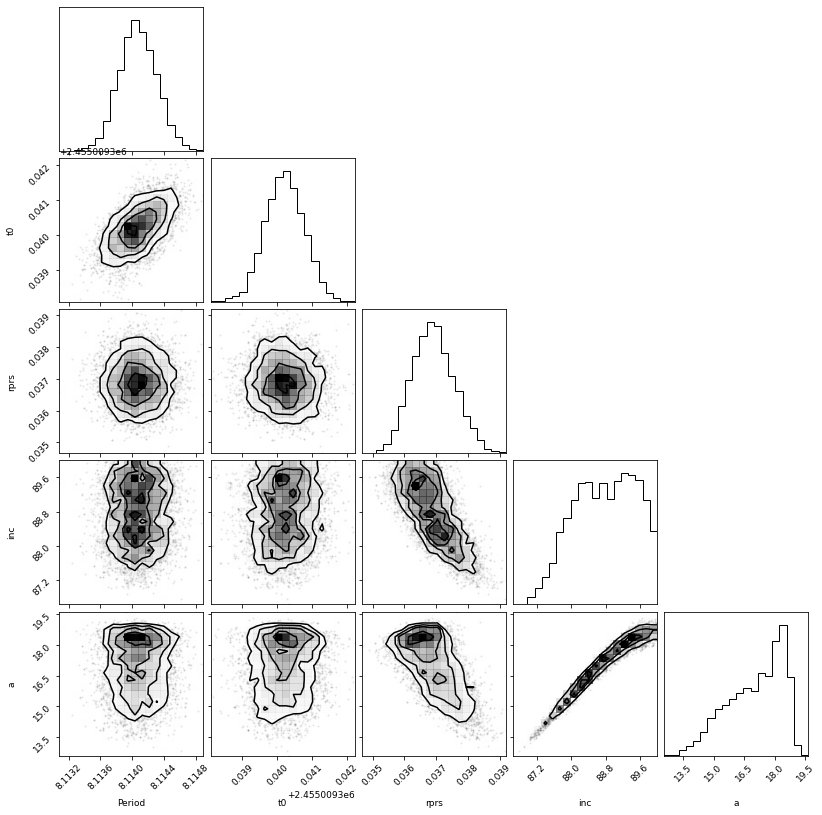

In [111]:
# Plot the transit fit corner plot
p = results.posteriors['posterior_samples']['P_p1']
t0 = results.posteriors['posterior_samples']['t0_p1']
rprs = results.posteriors['posterior_samples']['p_p1']
b = results.posteriors['posterior_samples']['b_p1']
a = results.posteriors['posterior_samples']['a_p1']
inc = np.arccos(b*(1./a))*(180./np.pi)

params = ['Period', 't0', 'rprs', 'inc', 'a']

fs = np.vstack((p, t0, rprs, inc, a))
fs = fs.T

figure = corner.corner(fs, labels=params)

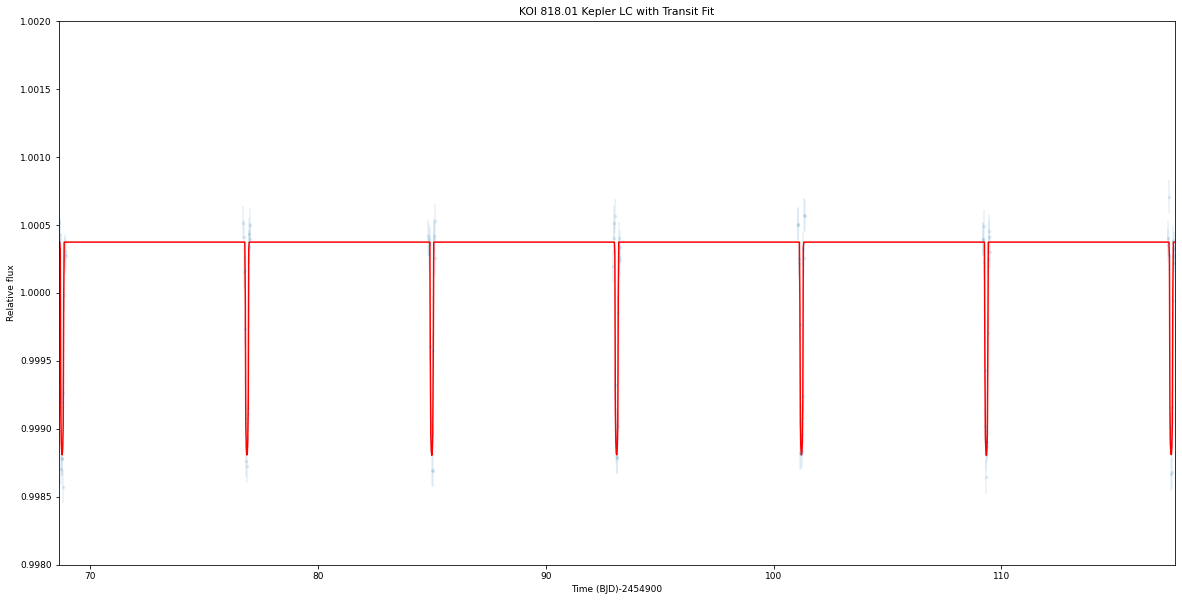

In [112]:
# Plot the data:
plt.errorbar(dataset.times_lc['KEPLER']-2454900, dataset.data_lc['KEPLER'], \
             yerr = dataset.errors_lc['KEPLER'], fmt = '.', alpha = 0.1)

# Plot the model:
plt.plot(dataset.times_lc['KEPLER']-2454900, results.lc.evaluate('KEPLER'), c='r')

# Plot portion of the lightcurve, axes, etc.:
plt.xlabel('Time (BJD)-2454900')
plt.xlim(np.min(dataset.times_lc['KEPLER'])-2454900, np.max(dataset.times_lc['KEPLER'])-2454900)
plt.ylim(0.998, 1.002)
plt.ylabel('Relative flux')
plt.title('KOI 818.01 Kepler LC with Transit Fit')
plt.show()

### Determining T14 and T23

In [113]:
koi.calc_durations()

In [114]:
print('Total Transit Duration: ', np.mean(koi.T14_dist), '-/+', koi.T14_errs, 'hours')
print('Full Transit Duration: ', np.mean(koi.T23_dist), '-/+', koi.T23_errs, 'hours')

Total Transit Duration:  0.1453917067458673 -/+ (0.0024099101024557534, 0.0029148854669333313) hours
Full Transit Duration:  0.1328974496125958 -/+ (0.002286337605429317, 0.002373614271698049) hours


### Get $g$

Print $g$ and $\sigma_{g}$:

In [115]:
koi.get_gs()

In [116]:
g_mean = koi.g_mean
g_sigma = koi.g_sigma

In [117]:
g_mean

0.7138312721212587

In [118]:
g_sigma

0.056832865957797074

The mean of $g$ is about 1.0, which means that $\rho_{circ}$ agrees with $\rho_{star}$ and the eccentricity of this transit must be zero, which is exactly what we input! We can take $g$ and $\sigma_{g}$ and use nested sampling (`dynesty`) to determine the surface of most likely $(e,w)$.

`photoeccentric` has the probability function for $(e,w)$ from $g$ built in to `ph.log_probability()`.

In [119]:
koi.do_eccfit(direct)

22184it [02:18, 160.69it/s, batch: 15 | bound: 0 | nc: 1 | ncall: 262862 | eff(%):  8.439 | loglstar:   -inf <  2.868 <  2.745 | logz:  0.281 +/-  0.074 | stop:  0.795]         


In [120]:
with open(direct + '/kepewdres.pickle', 'rb') as f:
    ewdres = pickle.load(f)

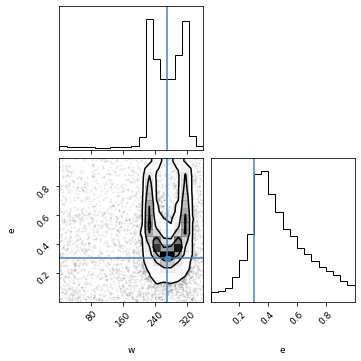

In [121]:
labels = ["w", "e"]

fig = corner.corner(ewdres.samples, labels=labels, title_kwargs={"fontsize": 12}, truths=[w, e], plot_contours=True)

And here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 0.7$. This $e$ distribution peaks at 0.3 too!